In [1]:
# Import Required Modules
from flask import Flask, render_template
import pandas as pd
import json
import plotly
import plotly.express as px
import pandas_ta as pta
from plotly.subplots import make_subplots
import plotly.graph_objects as go
from datetime import date
from datetime import timedelta, date
from prophet import Prophet
import pandas as pd
import numpy as np
import yfinance as yf




df = pd.read_csv("Resources/btcjoin.csv", parse_dates=['date'])
btc_df = yf.Ticker('BTC-USD').history(period='7y',interval='1d',actions=False).reset_index()
btc_df = btc_df.loc[(btc_df['Date'] > '2022-10-25')]
btc_df['Close']=btc_df['Close'].astype("float")
df['price']=df['price'].str.replace(',','')
df['price']=df['price'].astype("float")
btc_df = btc_df.rename(columns={"Close": "price", "Date":"date"})
df = pd.merge(df, btc_df, on=['date', 'price'], how='outer')
df = df.rename(columns={"value": "wallets"})
df = df.drop(columns=['volume','change', 'low', 'high', 'open','Open','High','Low','Unnamed: 0', "wallets", "address", "mined"])
df['200D'] = df['price'].rolling(200).mean()
df['300D'] = df['price'].rolling(300).mean()
df['50D'] = df['price'].rolling(50).mean()
df['7D'] = df['price'].rolling(7).mean()
# df = df.dropna()
df['meanavge'] = (df['200D'] + df['300D'] + df['50D'] )/3
# df = df.drop(columns=['200D','300D', '50D'])
df['meanvalue'] = df["price"] - df["meanavge"]
df['status'] = df['meanvalue'].apply(lambda x: '1' if x > 0 else '0')
df['status']=df['status'].astype("object")
df['price-meanavge']=df['price'] - df['meanavge']
df['move%'] = 100*(df['price-meanavge']/(df['price'] + df['meanavge']))
bins = [-43, -18, 0, 18, 43]
group_names = ["Severely Oversold","Neutral Oversold", "Neutral Overbought","Severely Overbought"]
df["Valuation"] = pd.cut(df["move%"], bins, labels=group_names)

k = df['price'].ewm(span=12, adjust=False, min_periods=12).mean()

# Get the 12-day EMA of the closing price
d = df['price'].ewm(span=26, adjust=False, min_periods=26).mean()

# Subtract the 26-day EMA from the 12-Day EMA to get the MACD
macd = k - d

# Get the 9-Day EMA of the MACD for the Trigger line
macd_s = macd.ewm(span=9, adjust=False, min_periods=9).mean()

# Calculate the difference between the MACD - Trigger for the Convergence/Divergence value
macd_h = macd - macd_s

# Add all of our new values for the MACD to the dataframe
df['macd'] = df.index.map(macd)
df['macd_h'] = df.index.map(macd_h)
df['macd_s'] = df.index.map(macd_s)


df['priceL'] = np.log(df['price'])

df_train = df[['date', 'priceL']]
df_train = df_train.rename(columns = {"date":"ds", "priceL":"y"})

# instantiate the model and set parameters
model = Prophet()

# fit the model to historical data
model.fit(df_train);

start = "2010-09-25"
end = date.today() + timedelta(days=60)
insample = pd.DataFrame(pd.date_range(start,end, periods=92))

# Change the column name
insample.columns = ['ds']

# in-sample prediction
prediction = model.predict(insample)


# Buy Zones
fig = px.scatter(df, x="date", y="price", color="Valuation", color_discrete_sequence=["red","green","blue","orange"],
                title="price")
fig.add_trace(go.Scatter(name="MeanAvg", x=df['date'], y=df['meanavge'], marker = {'color' : 'black'}, legendrank=2))
fig.add_trace(go.Scatter(x=prediction['ds'], y=np.exp(prediction['yhat']),
    fill=None,
    mode='lines',
    line_color='lightblue',
    ))
fig.add_trace(go.Scatter(
    x=prediction['ds'],
    y=np.exp(prediction['yhat_lower']),
    fill='tonexty', # fill area between trace0 and trace1
    mode='lines', line_color='lightblue'))

fig.add_trace(go.Scatter(
    x=prediction['ds'],
    y=np.exp(prediction['yhat_upper']),
    fill='tonexty', # fill area between trace0 and trace1
    mode='lines', line_color='lightblue'))

fig.update_yaxes(fixedrange=False)
fig.update_layout(title_text='Bitcoin Prophet Model + Buy Zones')
fig.update_yaxes(type="log")
fig.update_xaxes(ticklabelposition="inside top", title="Date")
fig.update_yaxes(nticks=12)
fig.update_xaxes(nticks=50)
fig.update_layout(
    margin=dict(l=20, r=100, t=70, b=20),
)
fig.update_layout(height=500, width=1000)
fig.update_layout(showlegend=False)
fig.add_vline(x='2012-11-28', line_width=3, line_dash="dash", line_color="green")
fig.add_vline(x='2016-07-09', line_width=3, line_dash="dash", line_color="green")	
fig.add_vline(x='2020-05-11', line_width=3, line_dash="dash", line_color="green")	
fig.add_vline(x='2024-04-02', line_width=3, line_dash="dash", line_color="green")

Buyzones = json.dumps(fig, cls=plotly.utils.PlotlyJSONEncoder)

fig = px.scatter(df, x="date", y="price", color="Valuation", color_discrete_sequence=["red","green","blue","orange"],
                title="price")
fig.add_trace(go.Scatter(name="200D", x=df['date'], y=df['200D'], marker = {'color' : 'red'}, legendrank=2))
fig.add_trace(go.Scatter(name="MeanAverage", x=df['date'], y=df['meanavge'], marker = {'color' : 'purple'}, legendrank=2))
fig.add_trace(go.Scatter(name="50D", x=df['date'], y=df['50D'], marker = {'color' : 'blue'}, legendrank=2))
fig.add_trace(go.Scatter(name="300D", x=df['date'], y=df['300D'], marker = {'color' : 'black'}, legendrank=2))

# Moving Averages
fig.update_yaxes(fixedrange=False)
fig.update_layout(title_text='Moving Averages')
fig.update_yaxes(type="log")
fig.update_xaxes(ticklabelposition="inside top", title="Date")
fig.update_yaxes(nticks=12)
fig.update_xaxes(nticks=50)
fig.update_layout(margin=dict(l=20, r=100, t=70, b=20))
fig.update_layout(height=500, width=1000)
fig.update_layout(showlegend=True)
fig.add_vline(x='2012-11-28', line_width=3, line_dash="dash", line_color="green")
fig.add_vline(x='2016-07-09', line_width=3, line_dash="dash", line_color="green")	
fig.add_vline(x='2020-05-11', line_width=3, line_dash="dash", line_color="green")	
fig.add_vline(x='2024-04-02', line_width=3, line_dash="dash", line_color="green")

Movingaverages = json.dumps(fig, cls=plotly.utils.PlotlyJSONEncoder)

# MACD

df_tail=df.dropna()
df_tail = df_tail.tail(360)
df_tail.head()

df_tail['RSI'] = pta.rsi(df_tail['price'], length = 14)

fig = make_subplots(rows=4, cols=1,shared_xaxes=True,vertical_spacing=0.01, row_heights=[0.2, 0.04,0.04,0.04])

fig.add_trace(
    go.Scatter(name="Price",x=df_tail['date'], y=df_tail['price'],
        marker=dict(color=df_tail['macd'], coloraxis="coloraxis1")),
    row=1, col=1)


fig.add_trace(
    go.Bar(name="macd",x=df_tail['date'], y=df_tail['macd'],
    marker=dict(color=df_tail['macd'], coloraxis="coloraxis1")),
    row=2, col=1)

fig.add_trace(
    go.Scatter(name="macd_s",x=df_tail['date'], y=df_tail['macd_s'],
    marker=dict(color=df_tail['macd_s'], coloraxis="coloraxis1")),
    row=2, col=1)

fig.add_trace(
    go.Scatter(name="macd_h",x=df_tail['date'], y=df_tail['macd_h'],
    marker=dict(color=df_tail['macd_h'], coloraxis="coloraxis1")),
    row=2, col=1)

fig.add_trace(go.Bar(x=df_tail['date'], y=df_tail['move%'],
                    marker=dict(color=df_tail['move%'], coloraxis="coloraxis2")),
            3, 1)

fig.add_trace(
    go.Scatter(name="RSI",x=df_tail['date'], y=df_tail['RSI'],
    marker=dict(color=df_tail['RSI'], coloraxis="coloraxis3")),
    row=4, col=1)

fig.update_yaxes(nticks=10)
fig.update_xaxes(nticks=50)
fig.update_layout(coloraxis1=dict(colorscale='Bluered_r'), showlegend=True)
fig.update_layout(coloraxis2=dict(colorscale='Bluered_r'), showlegend=True)
fig.update_layout(coloraxis3=dict(colorscale='Bluered_r'), showlegend=True)
fig.update_layout(coloraxis1_showscale=False)
fig.update_layout(coloraxis2_showscale=False)
fig.update_layout(height=700, width=1000, title_text="720 Day MACD, RSI, Price and Move%")
fig.update_layout(template='plotly_dark')

MACD = json.dumps(fig, cls=plotly.utils.PlotlyJSONEncoder)


#Indicators
fig = go.Figure(go.Indicator(
mode = "gauge+number",
title = {'text': "Current Valuation - Standard Deviation percent move from meanaverage", 'font': {'size': 15}},
value = df['move%'].iloc[-1],
domain = {'x': [0,1], 'y': [0,1]},
gauge = {
    'axis': {'range': [-0.43, 0.43], 'tickwidth': 1, 'tickcolor': "orange"},
    'bar': {'color': "orange"},
    'bgcolor': "white",
    'borderwidth': 2,
    'bordercolor': "white",
    'steps': [
        {'range': [-0.43, -0.18], 'color': 'red'},
        {'range': [-0.18, 0], 'color': 'yellow'},
        {'range': [0, 0.18], 'color': 'blue'},
        {'range': [0.18,0.43], 'color': 'green'}],
    }))

fig.update_layout(
    font={'color': "black", 'family': "Arial"},
    xaxis={'showgrid': False, 'range':[-1,1]},
    yaxis={'showgrid': False, 'range':[0,1.11]},
    plot_bgcolor='rgba(0,0,0,0)'
    )
# Set the visibility ON
fig.update_yaxes(title='', visible=True, showticklabels=False)
# Set the visibility OFF
fig.update_xaxes(title='x', visible=False, showticklabels=False)

Indicators = json.dumps(fig, cls=plotly.utils.PlotlyJSONEncoder)

# YTD

def get_ytd_returns(ticker):
    df = yf.Ticker(ticker).history(period='ytd',interval='1d',actions=False).reset_index()
    ytd_return = ((df.Close.iloc[-1]/df.Close.iloc[0])-1)
    return ytd_return

tickers = ['BTC-USD', 'GC=F', 'Cl=F', 'TLT', 'DX=F', '^RUT', '^GSPC', '^IXIC', '^DJI', 'BIGPX']
asset_names = ['Bitcoin', 'Gold', 'Oil', '20yr Treasury', 'DXY', 'Russell 2000 Index', 'S&P 500', 'NASDAQ', 'Dow Jones', '60/40']

data = [[asset_name, get_ytd_returns(ticker)*100] for asset_name, ticker in zip(asset_names, tickers)]

# Create the pandas DataFrame
data = pd.DataFrame(data, columns=['Asset', 'YTD%'])
data['YTD%'] = data['YTD%'].round(2)

fig = px.bar(data, x='YTD%', y='Asset', orientation='h', text=str("YTD%"), color="YTD%",color_continuous_scale=px.colors.sequential.Oryel)
fig.layout.yaxis.tickformat = ',.%'
fig.update_layout(title_text='Year To Date Returns')
fig.update_layout(yaxis=dict(showticklabels=True))
fig.update_layout(height=500, width=1000, title_text="YTD Returns")

YTD = json.dumps(fig, cls=plotly.utils.PlotlyJSONEncoder)

# Corr





19:47:07 - cmdstanpy - INFO - Chain [1] start processing
19:47:13 - cmdstanpy - INFO - Chain [1] done processing


In [2]:
tickers_list = ['BTC-USD','DX=F', '^GSPC', '^IXIC', 'GC=F']

# Fetch data for all tickers using a for loop
data = {}
for ticker in tickers_list:
    data[ticker] = yf.Ticker(ticker).history(period='3mo', interval='1d', actions=False)['Close']

# Filter out NaN values using list comprehension
data = {ticker: close[~close.isna()] for ticker, close in data.items()}

# Merge data using inner join
merge = pd.concat(data, axis=1, join='inner')
merge.columns = [ticker for ticker, close in data.items()]

# Rename columns
merge = merge.rename(columns={"BTC-USD": "BTC", "DX=F": "DXY", "^GSPC": "S&P500", "^IXIC": "Nasdaq", "GC=F": "Gold"})
assets = [('DXY', 'DXY/BTC'), ('S&P500', 'S&P500/BTC'), ('Nasdaq', 'Nasdaq/BTC'), ('Gold', 'Gold/BTC')]

# Use a for loop to calculate the correlation for each asset pair
correlations = {}
for asset, col_name in assets:
    correlations[col_name] = merge['BTC'].rolling(3).corr(merge[asset])

merge = merge.assign(**correlations).dropna().reset_index()
corr_matrix=merge.drop(columns=['DXY/BTC','S&P500/BTC', 'Nasdaq/BTC', 'Gold/BTC'])
corr_matrix = corr_matrix.corr().round(2)
fig = px.imshow(corr_matrix,color_continuous_scale='Oryel',text_auto=".2f", aspect="auto")
fig.update_layout(height=500, width=1000, title_text="Correlation Matrix")

fig.show()

NameError: name 'mpld3' is not defined

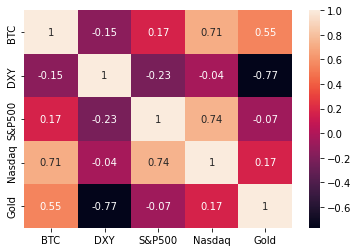

In [3]:
import numpy as np 
from pandas import DataFrame
import seaborn as sns
%matplotlib inline


sns.heatmap(corr_matrix, annot=True)
json_figs = mpld3.fig_to_dict(fig)

In [ ]:
import json
import numpy as np
import mpld3
import matplotlib.pyplot as plt

# create a 2D numpy array to use as the heatmap data
heatmap_data = np.random.rand(10, 10)

# create the heatmap using matplotlib
fig, ax = plt.subplots()
heatmap = ax.imshow(heatmap_data, cmap='YlOrRd')

# add annotations to the heatmap
for i in range(heatmap_data.shape[0]):
    for j in range(heatmap_data.shape[1]):
        text = ax.text(j, i, f"{heatmap_data[i, j]:.2f}", ha="center", va="center", color="black")

# add a colorbar to the heatmap
colorbar = plt.colorbar(heatmap)

# convert the figure to a JSON-compatible object using mpld3
json_figs = mpld3.fig_to_dict(fig)

# encode the JSON object to a string using json.dumps()
corr1 = json.dumps(json_figs)

